# Simulating the effect of pixelization errors on Gaussian fittings

## Importing packages

In [1]:
import os
import sys
sys.path.append('./')

import math
import numpy as np
from numpy import size
from scipy.optimize import curve_fit

import matplotlib
matplotlib.use('PDF')
import matplotlib.pyplot as plt
%matplotlib inline

## Defining functions and classes

In [6]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [35]:
# parent class
class spectrum:
  'Parent class for a spectrum \n \
     Attributes \n \
     num_components ( int ) : counters for total number of spectra \n \
  '
  num_components = 0
    
  def __init__(self):
    spectrum.num_components += 1
    
  def __del__(self):
    spectrum.num_components -= 1
    

    
# subclasses
class gaussian_spectrum( spectrum ):
  'Sub-class of spectrum. Gaussian profile \n \
     constructed by, e.g., spectrum1 = gaussian_spectrum() \n\n \
   Attributes: \n \
   A (float) : Amplitude of the gaussian spectrum \n \
   sigma (float) : standard deviation [bins] of the gaussian spectrum \n \
   bins (int) : number of bins to sample the spectrum. \n \
   data (numpy array) : the stored intensity values \n \
   resampleddata (numpy array) : the stored, resampled intensity values \n \
  '

  num_components = 0

  def __init__(self, name = 'gaussian_unknown', 
               A=1.0, sigma=1.0, bins=256):
    spectrum.num_components += 1
    gaussian_spectrum.num_components += 1
    self.name  = name
    self.A = A
    self.sigma = sigma
    self.bins  = bins
    self.x     = np.arange(0, bins)
    self.center = float(bins - 1) / 2.0

    self.data = \
      A * np.exp( - ( self.x - self.center)**2.0 / (2.0 * sigma**2) )
    self.resampleddata = self.data
    # print( self.name )
    # print( self.data )
    
  def __del__(self):
    spectrum.num_components -= 1
    gaussian_spectrum.num_components -= 1

  def resample(self, pixelsize=20, pixelshift=10):
    # pixelsize: pixelsize in units of bin
    # pixelshift: In unit of bin. A parameter to shift the resampling pixels with respect to the
    #             original Gaussian spectrum
    
    for i in range(0, pixelshift):
        self.resampleddata[i] = np.sum( self.data[0:pixelshift] ) / pixelsize

    resampled_bins = int( 
                         ( self.bins - pixelshift ) / pixelsize
                        )
    for i in range(0, resampled_bins):
      for j  in range(0, pixelsize):
        k = pixelshift + pixelsize * i + j
        start = pixelshift + pixelsize * i
        end   = pixelshift + pixelsize * (i+1)
        self.resampleddata[k] = np.sum( self.data[start:end] ) / pixelsize
        
  def add_noise(self, RMS=0.1):
    # RMS: the RMS noise level
    noise = np.random.normal(0.0, RMS, self.bins)
    self.data = self.data + noise
    
  def refit_gaussian(self):
    p0 = [1., self.bins/2.0, 1.]
    coeff, var_matrix = curve_fit(gauss, self.x, self.resampleddata, p0=p0)
    return coeff
    

## Printing help files

In [36]:
print ( 'spectrum :\n', spectrum.__doc__ )
print ( 'gaussian_spectrum :\n', gaussian_spectrum.__doc__ )

spectrum :
 Parent class for a spectrum 
      Attributes 
      num_components ( int ) : counters for total number of spectra 
   
gaussian_spectrum :
 Sub-class of spectrum. Gaussian profile 
      constructed by, e.g., spectrum1 = gaussian_spectrum() 

    Attributes: 
    A (float) : Amplitude of the gaussian spectrum 
    sigma (float) : standard deviation [bins] of the gaussian spectrum 
    bins (int) : number of bins to sample the spectrum. 
    data (numpy array) : the stored intensity values 
    resampleddata (numpy array) : the stored, resampled intensity values 
   


## Plotting results

[  0.87909039 127.21913374  10.81075322]


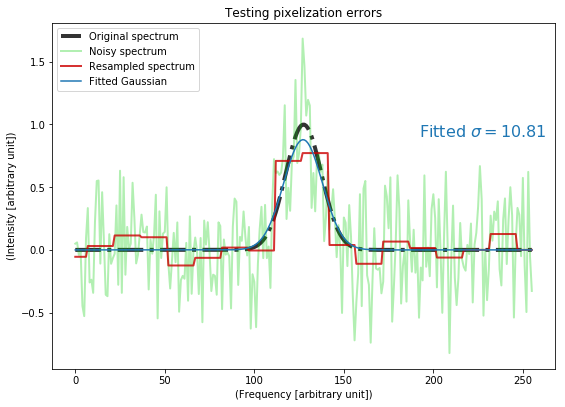

In [62]:
test_spectrum = gaussian_spectrum(name='test', A=1.0, sigma=10.0, bins=256)

fig = plt.figure(figsize=(9, 14))
plt.subplot(2, 1, 1)

# plotting the original gaussian spectrum
plt.plot(test_spectrum.x , test_spectrum.data, \
         '-.',
         color = (0, 0, 0.0, 0.8),
         linewidth=4, label = 'Original spectrum')    

# inject noise
test_spectrum.add_noise(RMS=0.3)
plt.plot(test_spectrum.x , test_spectrum.data, \
         color = (0, 0.8, 0.0, 0.3),
         linewidth=2, label = 'Noisy spectrum')    

# resampling
test_spectrum.resample(pixelsize=15, pixelshift=7)
plt.plot(test_spectrum.x , test_spectrum.resampleddata, \
         color = (0.8, 0.0, 0.0, 0.8),
         linewidth=2, label = 'Resampled spectrum')    

# fit Gaussian and print the results
coeff = test_spectrum.refit_gaussian()
print( coeff )
plt.text( test_spectrum.bins*0.75, 0.9,
         'Fitted $\sigma=$%s' %(str( round( coeff[2], 2) ) ), 
         {'color': 'C0', 'fontsize': 16})

spectrum_fit = gauss( test_spectrum.x, *coeff)
plt.plot(test_spectrum.x, spectrum_fit, label='Fitted Gaussian')

plt.title('Testing pixelization errors')
plt.xlabel( '(Frequency [arbitrary unit])')
plt.ylabel( '(Intensity [arbitrary unit])')
plt.legend(loc=2)